# Example 2.1-2
From Parameter Estimation and Inverse Problems, 2nd edition, 2011   
by R. Aster, B. Borchers, C. Thurber

### Author:
* Nima Nooshiri [@nimanzik](https://github.com/nimanzik)

In [1]:
%reset -f

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as nla
from scipy import stats
from scipy.io import loadmat

In [3]:
plt.style.use('ggplot')
plt.style.use('./data/peiplib.mplstyle')

# Example 2.1

We consider linear regression of ballistic observations to a quadratic model, where the regression model is:

$y(t) = m_0 + m_1 t - (1/2) m_2 t^{2}$

## Synthetic Data Set

Consider a synthetic data set with $m = 10$ observations and independent normal data errors ($\sigma = 8$ m), generated
using $\textbf{m}_{\textrm{true}} = [10~\textrm{m}, 100~\textrm{m/s}, 9.8~\textrm{m/s}^{2}]^T$:

In [4]:
# True model parameters
m_true = np.array([10, 100, 9.8])

# Load precomputed data
matdata = loadmat('./data/data1.mat', squeeze_me=True)
t, y, sigma = matdata['data1'].T
n_obs = t.size
t, y, sigma

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([109.3827, 187.5385, 267.5319, 331.8753, 386.0535, 428.4271,
        452.1644, 498.1461, 512.3499, 512.9753]),
 array([8., 8., 8., 8., 8., 8., 8., 8., 8., 8.]))

## Weighted Least-Squares Solutions

To obtain the least squares solution, we construct the $\textbf{G}$ matrix. The _i-th_ row of $\textbf{G}$ is given by:

$G_{i,.} = [1, t_i, -(1/2)t_{i}^{2}]$

so that

In [5]:
G = np.array([np.ones_like(t), t, -0.5 * t**2]).T
G

array([[  1. ,   1. ,  -0.5],
       [  1. ,   2. ,  -2. ],
       [  1. ,   3. ,  -4.5],
       [  1. ,   4. ,  -8. ],
       [  1. ,   5. , -12.5],
       [  1. ,   6. , -18. ],
       [  1. ,   7. , -24.5],
       [  1. ,   8. , -32. ],
       [  1. ,   9. , -40.5],
       [  1. ,  10. , -50. ]])

To incorporate the data standard deviations into the weighted least squares solution, we scale the system of equations to obtain a weighted system of equations.

In [6]:
W = np.identity(n_obs) / sigma
Gw = W @ G
yw = W @ y

We solve for the parameters using the weighted normal equations, to obtain a model estimate:

In [7]:
m_est = nla.inv(Gw.T @ Gw) @ Gw.T @ yw
m_est

array([16.41740833, 96.96765856,  9.40753561])

Figure below shows the observed data and the fitted curve:

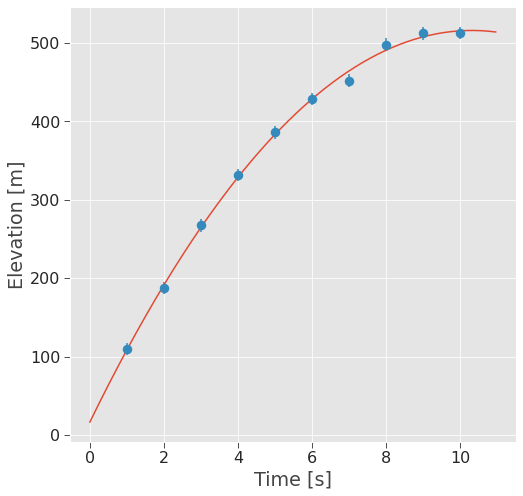

In [8]:
x = np.arange(t.min() - 1, t.max() + 1, step=0.05)
y_est = m_est[0] + (m_est[1] * x) - (0.5 * m_est[2] * x**2)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, y_est)
ax.errorbar(t, y, yerr=sigma, fmt='o')
ax.set(xlabel='Time [s]', ylabel='Elevation [m]');

The model covariance matrix associated with weighted least-squares solutions `m_est` is:

In [9]:
covmat = nla.inv(Gw.T @ Gw)

print('Covariance matrix for fitted parameters:')
covmat

Covariance matrix for fitted parameters:


array([[ 88.53333333, -33.6       ,  -5.33333333],
       [-33.6       ,  15.44242424,   2.66666667],
       [ -5.33333333,   2.66666667,   0.48484848]])

For this example, parameter estimates with 95% confidence intervals (1.96-sigma) are:

In [10]:
z = stats.norm.ppf(0.975)   # z = 1.96
ci = z * np.sqrt(np.diag(covmat))

print(
    f'95% parameter confidence intervals:',
    f'  {m_est[0]:5.2f} +- {ci[0]:5.2f}',
    f'  {m_est[1]:5.2f} +- {ci[1]:5.2f}',
    f'  {m_est[2]:5.2f} +- {ci[2]:5.2f}',
    sep='\n')

95% parameter confidence intervals:
  16.42 +- 18.44
  96.97 +-  7.70
   9.41 +-  1.36


Because there are 3 parameters to estimate, we have `n_obs - 3` degrees of freedom.   
The $\chi^{2}$ value for this regression is approximately 4.2:

In [11]:
residuals = y - (G @ m_est)
chi_sq = np.sum(residuals**2 / sigma**2)
dof = G.shape[0] - G.shape[1]

print(f'Chi-square misfit for {dof} degrees of freedom: {chi_sq:.2f}')

Chi-square misfit for 7 degrees of freedom: 4.20


Now, we find the $p$-value for this test:

In [12]:
pval = 1.0 - stats.chi2.cdf(chi_sq, dof)

print(f'chi-square p-value: {pval:.2f}')

chi-square p-value: 0.76


---

## Example 2.2

In this example, we plot the 95% error ellipses for each pair of parameters.   
Note that since we are considering pairs of parameters, there are 2 degrees of freedom in the Chi-square here, rather than 3.

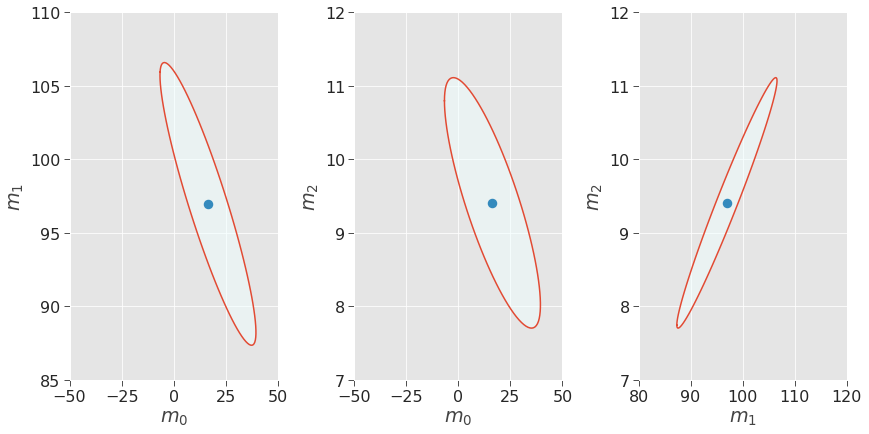

In [13]:
def helper_plot_confidence_ellipse(c, m, ax):
    delta = np.sqrt(stats.chi2.ppf(0.95, 2))
    
    eigvals, eigvecs = nla.eig(nla.inv(c))

    # Length of semi-axes
    a = delta / np.sqrt(eigvals[0])
    b = delta / np.sqrt(eigvals[1])

    # Generate a vector of angles from 0 to 2*pi
    angles = np.linspace(0, 2.0 * np.pi, 100)

    # Calculate the x and y component of the ellipsoid for all angles
    xs = (
        m[0]
        + a * np.cos(angles) * eigvecs[0, 0]
        + b * np.sin(angles) * eigvecs[0, 1])

    ys = (
        m[1]
        + a * np.cos(angles) * eigvecs[1, 0]
        + b * np.sin(angles) * eigvecs[1, 1])

    ax.plot(xs, ys)
    ax.fill(xs, ys, 'azure', alpha=0.5)
    ax.plot(*m, 'o')


# ----------

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
fig.tight_layout(w_pad=1.5)
ax1, ax2, ax3 = axes

# m0-m1 pair
c = covmat[np.ix_([0, 1], [0, 1])]
m = m_est[[0, 1]]
helper_plot_confidence_ellipse(c, m, ax1)
ax1.set(xlabel=r'$m_{0}$', ylabel=r'$m_{1}$', xlim=[-50, 50], ylim=[85, 110])

# m0-m2 pair
c = covmat[np.ix_([0, 2], [0, 2])]
m = m_est[[0, 2]]
helper_plot_confidence_ellipse(c, m, ax2)
ax2.set(xlabel=r'$m_{0}$', ylabel=r'$m_{2}$', xlim=[-50, 50], ylim=[7, 12])

# m1-m2 pair
c = covmat[np.ix_([1, 2], [1, 2])]
m = m_est[[1, 2]]
helper_plot_confidence_ellipse(c, m, ax3)
ax3.set(xlabel=r'$m_{1}$', ylabel=r'$m_{2}$', xlim=[80, 120], ylim=[7, 12]);